In [1]:
import numpy as np
import io
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
# Load and preprocess data
data_URL = '/content/drive/MyDrive/DL/shakespeare_train.txt'

with io.open(data_URL, 'r', encoding='utf-8') as f:
    text = f.read()

vocab = sorted(set(text))

vocab_to_int = {c:i for i, c in enumerate(vocab)}

int_to_vocab = np.array(vocab)
train_data = np.array([vocab_to_int[c] for c in text], dtype=np.int32)
char_dataset = tf.data.Dataset.from_tensor_slices(train_data)

seq_length = 20
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [3]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)


In [4]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Calculate the number of batches for training
total_batches = len(dataset)
train_batches = int(0.8 * total_batches)

# Split the dataset into training and validation datasets
train_dataset = dataset.take(train_batches)
val_dataset = dataset.skip(train_batches)

vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

def build_model_rnn(vocab_size, embedding_dim, rnn_units, batch_size):

    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
    return model

def build_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

model = build_model_rnn(vocab_size = len(vocab),embedding_dim=embedding_dim,rnn_units=rnn_units,batch_size=BATCH_SIZE)

model.summary()

(64, 20, 67) # (batch_size, sequence_length, vocab_size)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           17152     
                                                                 
 gru (GRU)                   (64, None, 1024)          3938304   
                                                                 
 dense (Dense)               (64, None, 67)            68675     
                                                                 
Total params: 4024131 (15.35 MB)
Trainable params: 4024131 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import os
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

# Directory where the checkpoints will be saved
checkpoint_dir = '/content/drive/MyDrive/DL/checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS=20
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Prediction shape:  (64, 20, 67)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.205208
Epoch 1/20
2589/2589 [==============================] - 56s 20ms/step - loss: 1.7868 - accuracy: 0.4778 - val_loss: 1.6840 - val_accuracy: 0.5054
Epoch 2/20
2589/2589 [==============================] - 55s 21ms/step - loss: 1.5616 - accuracy: 0.5324 - val_loss: 1.6395 - val_accuracy: 0.5178
Epoch 3/20
2589/2589 [==============================] - 53s 20ms/step - loss: 1.5237 - accuracy: 0.5416 - val_loss: 1.6250 - val_accuracy: 0.5203
Epoch 4/20
 467/2589 [====>.........................] - ETA: 42s - loss: 1.4955 - accuracy: 0.5492

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

# Define different configurations
hidden_units_list = [256, 512, 1024] #
seq_length_list = [50, 100, 150]

# Initialize a dictionary to store training losses for different configurations
training_losses = {}

# Iterate through different configurations
for hidden_units in hidden_units_list:
    for seq_length in seq_length_list:
        # Build the RNN model
        model = build_model_rnn(vocab_size = len(vocab),embedding_dim=embedding_dim,rnn_units=rnn_units,batch_size=BATCH_SIZE)

        # Compile the model
        model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

        # Train the model
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

        # Store training loss for the current configuration
        config_key = f'HiddenUnits_{hidden_units}_SeqLength_{seq_length}'
        training_losses[config_key] = history.history['loss']

# Plot training losses for different configurations
plt.figure(figsize=(12, 8))

for config_key, loss_values in training_losses.items():
    plt.plot(loss_values, label=config_key)

plt.title('Training Loss for Different Configurations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/5
2589/2589 [==============================] - 57s 20ms/step - loss: 1.7840 - accuracy: 0.4787 - val_loss: 1.6923 - val_accuracy: 0.5026
Epoch 2/5
2589/2589 [==============================] - 58s 22ms/step - loss: 1.5612 - accuracy: 0.5326 - val_loss: 1.6369 - val_accuracy: 0.5170
Epoch 3/5
2589/2589 [==============================] - 52s 20ms/step - loss: 1.5223 - accuracy: 0.5422 - val_loss: 1.6212 - val_accuracy: 0.5193
Epoch 4/5
2589/2589 [==============================] - 55s 21ms/step - loss: 1.5046 - accuracy: 0.5465 - val_loss: 1.6139 - val_accuracy: 0.5233
Epoch 5/5
2589/2589 [==============================] - 59s 23ms/step - loss: 1.4944 - accuracy: 0.5490 - val_loss: 1.6094 - val_accuracy: 0.5253
Epoch 1/5
2589/2589 [==============================] - 55s 20ms/step - loss: 1.7906 - accuracy: 0.4773 - val_loss: 1.6897 - val_accuracy: 0.5038
Epoch 2/5
2589/2589 [==============================] - 54s 20ms/step - loss: 1.5620 - accuracy: 0.5324 - val_loss: 1.6394 - val_ac

In [7]:
checkpoint_file = '/content/drive/MyDrive/DL/checkpoints/ckpt_23'

model = build_model_rnn(vocab_size, embedding_dim, rnn_units, batch_size=1)

# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.load_weights(checkpoint_file)

model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            17152     
                                                                 
 gru_2 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_2 (Dense)             (1, None, 67)             68675     
                                                                 
Total params: 4024131 (15.35 MB)
Trainable params: 4024131 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
input_eval = [vocab_to_int[s] for s in "peo"]
input_eval = tf.expand_dims(input_eval, 0)
predictions = model(input_eval)
predictions = tf.squeeze(predictions, 0)
predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
print("input = peo", "\noutput =", int_to_vocab[predicted_id])

input = peo 
output = p


In [9]:
def generate_text(model, start_string):

    num_generate = 1000
    input_eval = [vocab_to_int[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)


    text_generated = []

    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(int_to_vocab[predicted_id])

    return (start_string + ''.join(text_generated))

In [11]:
print(generate_text(model, start_string=u"JULIET"))

JULIET:
In truth, ones may drown your trusten nights.
My dukedow him rusty have to dine, and on our England, whom we might.

Servant:
So this is Diomedest stand enow it was when you were worth
That Brutus have weight o'er;
And in this tongued has at this praise over
Is profit value down and make a sore within
the earth for want of pup bewith the drowsy time,
For all the patience of Venice, this had not been with, we, my best-skill be known
To meet him to yourselves;
And 'tis no slave, and west
Our quiet, which cannd with her;
But dear, and present thou mayst see him post
To this proce posseritary-mangled Titus,
You know let me hear this grace
shroubled mine aspect, Noble Macbeth, 'tis safe,
Let me not cheer it.

CRESSIDA:
O, 'tis up, I tout and heartily;
I send the time with the daintiest charm be said
Against their own disgrace ambitions:
Sellect your respect: if we have anster,
But marcleth you, we must content for that man's
saw Sir John.

FLUELLEN:
I'll have a tongue that he unvest

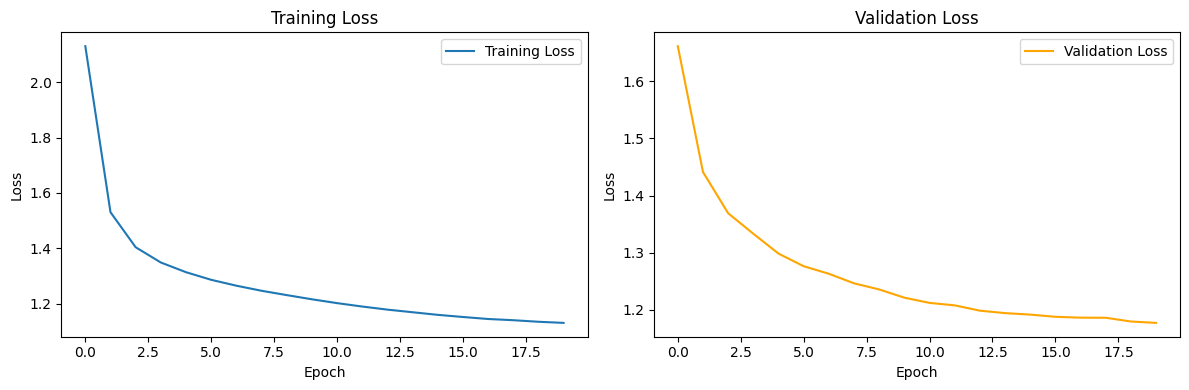

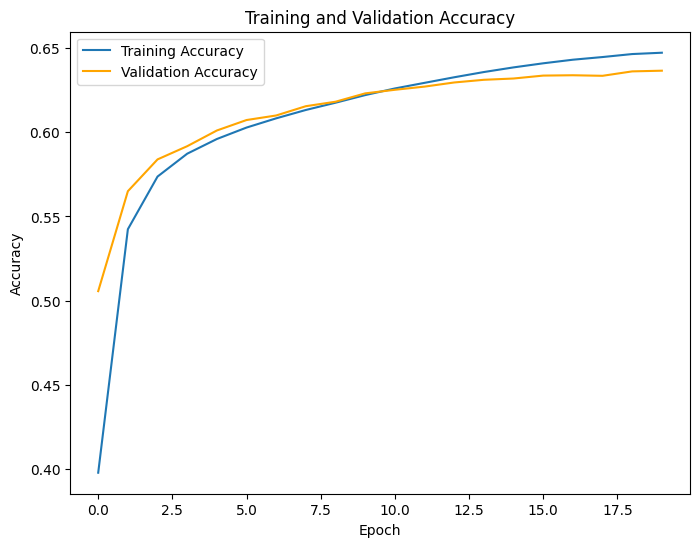

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()

# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot learning curve (accuracy)
plt.figure(figsize=(8, 6))

# Plot Training Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# Assuming you have validation data
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
